# 1 - Setup

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout

import yfinance as yf # data source

import datetime

# 2 - Data Acquisition

In [2]:
ticker_symbol = "BTC-USD"
start_date = "2018-01-01"
end_date = datetime.date.today().strftime("%Y-%m-%d")
data = yf.download(ticker_symbol, start=start_date, end=end_date)

/tmp/ipython-input-2-2755054804.py:4: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(ticker_symbol, start=start_date, end=end_date)
[*********************100%***********************]  1 of 1 completed


# 3 - EDA

In [3]:
data.tail()

Price,Close,High,Low,Open,Volume
Ticker,BTC-USD,BTC-USD,BTC-USD,BTC-USD,BTC-USD
Date,,,,,
2025-07-22,119995.414062,120269.968750,116233.226562,117426.500000,79217583118
2025-07-23,118754.960938,120113.351562,117391.390625,119997.445312,66608604537
2025-07-24,118368.000000,119535.453125,117247.968750,118770.984375,72627318560
2025-07-25,117635.882812,118486.976562,114759.820312,118368.000000,104857024569
2025-07-26,117947.367188,118335.687500,117181.226562,117644.843750,48508954046


In [ ]:
data['Close'].tail()

Ticker,BTC-USD
Date,
2025-07-22,119995.414062
2025-07-23,118754.960938
2025-07-24,118368.000000
2025-07-25,117635.882812
2025-07-26,117947.367188


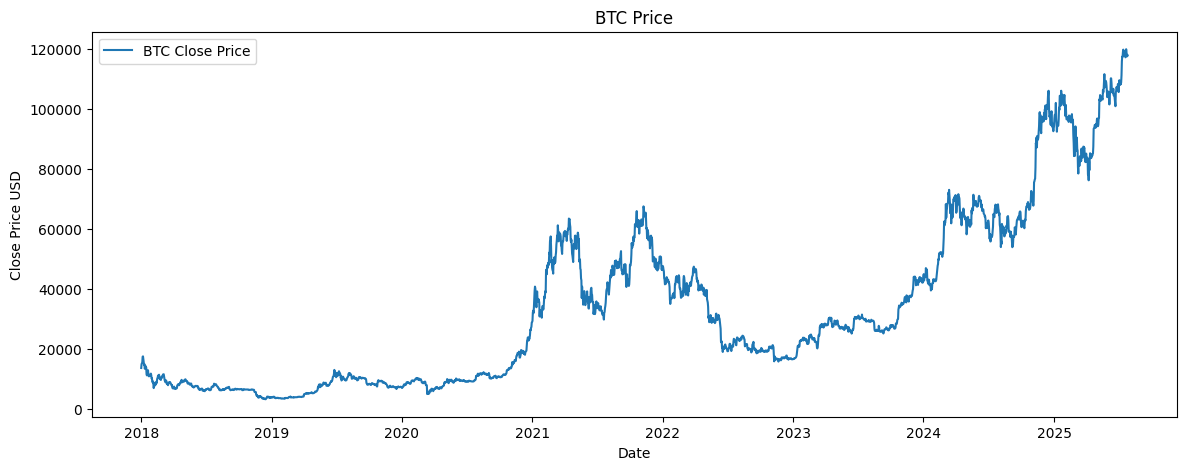

In [ ]:
plt.figure(figsize=(14, 5))
plt.plot(data['Close'], label='BTC Close Price')
plt.title('BTC Price')
plt.xlabel('Date')
plt.ylabel('Close Price USD')
plt.legend()
plt.show()

# 4 - Data Prep

In [ ]:
# Select the closing prices
close_prices = data['Close'].values
close_prices = close_prices.reshape(-1, 1)

close_prices

array([[ 13657.20019531],
       [ 14982.09960938],
       [ 15201.        ],
       ...,
       [118368.        ],
       [117635.8828125 ],
       [117947.3671875 ]])

In [ ]:
# Scale the data to be between 0 and 1
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(close_prices)

scaled_data

array([[0.08924768],
       [0.10059501],
       [0.10246982],
       ...,
       [0.98606173],
       [0.97979138],
       [0.98245914]])

In [ ]:
# Define the training data size
training_data_len = int(np.ceil(len(scaled_data) * 0.8))

training_data_len

2212

In [ ]:
# Split the data
train_data = scaled_data[:training_data_len]
test_data = scaled_data[training_data_len - 40:]

train_data.shape, test_data.shape

((2212, 1), (592, 1))

In [ ]:
# Create the training dataset
x_train, y_train = [], []

for i in range(40, len(train_data)):
    x_train.append(train_data[i-40:i, 0])
    y_train.append(train_data[i, 0])

x_train, y_train = np.array(x_train), np.array(y_train)
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))

x_train.shape, y_train.shape

((2172, 40, 1), (2172,))

# 5 - LSTM

In [ ]:
# Build the LSTM model
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(x_train.shape[1], 1)))
model.add(LSTM(units=50, return_sequences=False))
model.add(Dense(units=25))
model.add(Dense(units=1))
model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 40, 50)         │        10,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 50)             │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 25)             │         1,275 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            26 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 31,901 (124.61 KB)

 Trainable params: 31,901 (124.61 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

Epoch 1/10
1737/1737 ━━━━━━━━━━━━━━━━━━━━ 16s 8ms/step - loss: 0.0011 - val_loss: 1.0772e-04
Epoch 2/10
1737/1737 ━━━━━━━━━━━━━━━━━━━━ 13s 7ms/step - loss: 3.0594e-04 - val_loss: 1.0151e-04
Epoch 3/10
1737/1737 ━━━━━━━━━━━━━━━━━━━━ 21s 7ms/step - loss: 3.0170e-04 - val_loss: 3.9880e-05
Epoch 4/10
1737/1737 ━━━━━━━━━━━━━━━━━━━━ 22s 8ms/step - loss: 2.1291e-04 - val_loss: 7.3591e-05
Epoch 5/10
1737/1737 ━━━━━━━━━━━━━━━━━━━━ 13s 7ms/step - loss: 1.9562e-04 - val_loss: 4.6906e-05
Epoch 6/10
1737/1737 ━━━━━━━━━━━━━━━━━━━━ 14s 8ms/step - loss: 1.5539e-04 - val_loss: 7.1307e-05
Epoch 7/10
1737/1737 ━━━━━━━━━━━━━━━━━━━━ 13s 7ms/step - loss: 2.1331e-04 - val_loss: 3.6275e-05
Epoch 8/10
1737/1737 ━━━━━━━━━━━━━━━━━━━━ 20s 7ms/step - loss: 1.7184e-04 - val_loss: 3.4242e-05
Epoch 9/10
1737/1737 ━━━━━━━━━━━━━━━━━━━━ 13s 7ms/step - loss: 1.7843e-04 - val_loss: 1.0007e-04
Epoch 10/10
1737/1737 ━━━━━━━━━━━━━━━━━━━━ 13s 7ms/step - loss: 1.5600e-04 - val_loss: 2.1753e-04


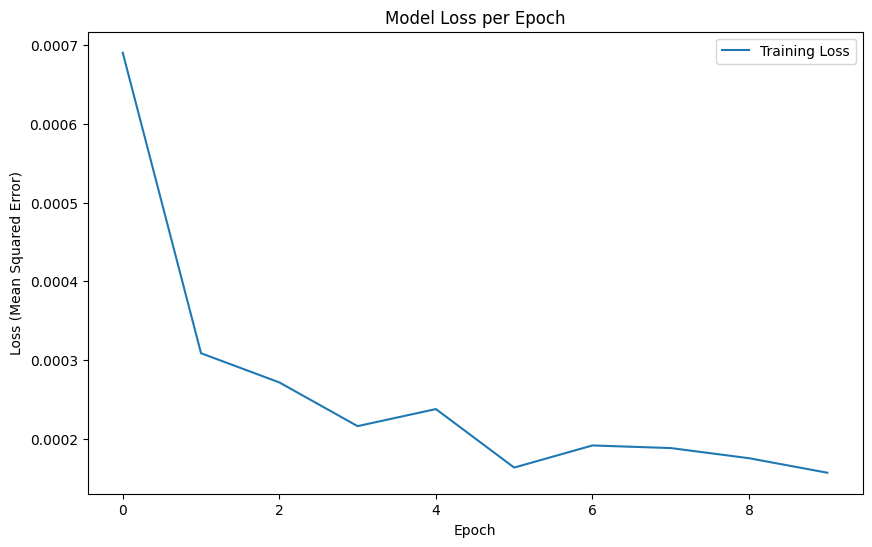

In [ ]:
# Train the model and capture the history
history = model.fit(x_train, y_train, validation_split=0.2, batch_size=1, epochs=10)

# Plot the training loss
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.title('Model Loss per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Loss (Mean Squared Error)')
plt.legend()
plt.show()

In [ ]:
# Create the test data
x_test = []
y_test = close_prices[training_data_len:]

for i in range(40, len(test_data)):
    x_test.append(test_data[i-40:i, 0])

x_test = np.array(x_test)
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))

In [ ]:
# Get the model's predicted price values
predictions = model.predict(x_test)
predictions = scaler.inverse_transform(predictions)

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


# 6 - Evaluation

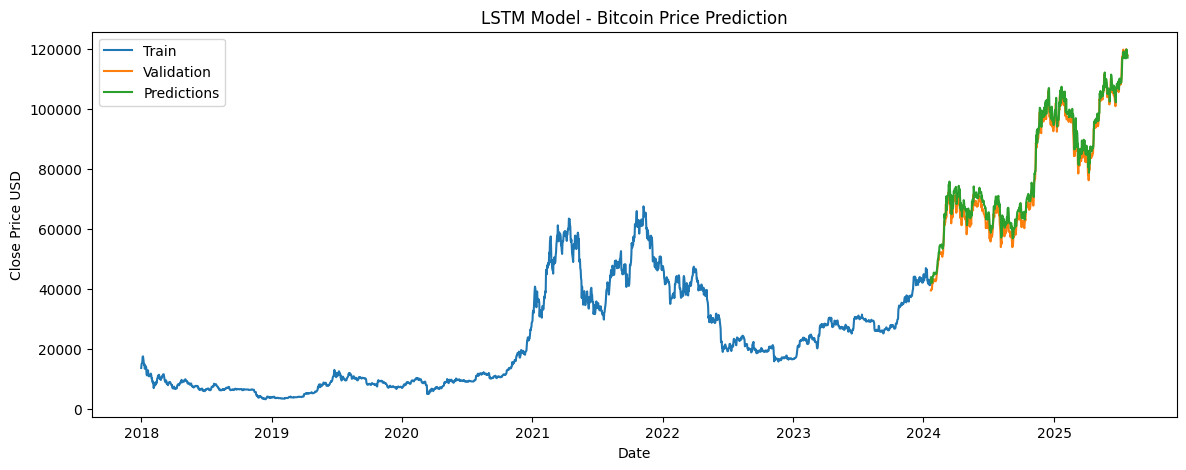

In [ ]:
# Plot the data
train = data[:training_data_len]
valid = data[training_data_len:].copy()
valid.loc[:, 'Predictions'] = predictions

plt.figure(figsize=(14, 5))
plt.plot(train['Close'], label='Train')
plt.plot(valid[['Close', 'Predictions']], label=['Validation', 'Predictions'])
plt.title('LSTM Model - Bitcoin Price Prediction')
plt.xlabel('Date')
plt.ylabel('Close Price USD')
plt.legend()
plt.show()

Root Mean Squared Error (RMSE): 2955.806827247004
Mean Absolute Error (MAE): 2486.315185546875
R-squared (R2): 0.9776724576950073


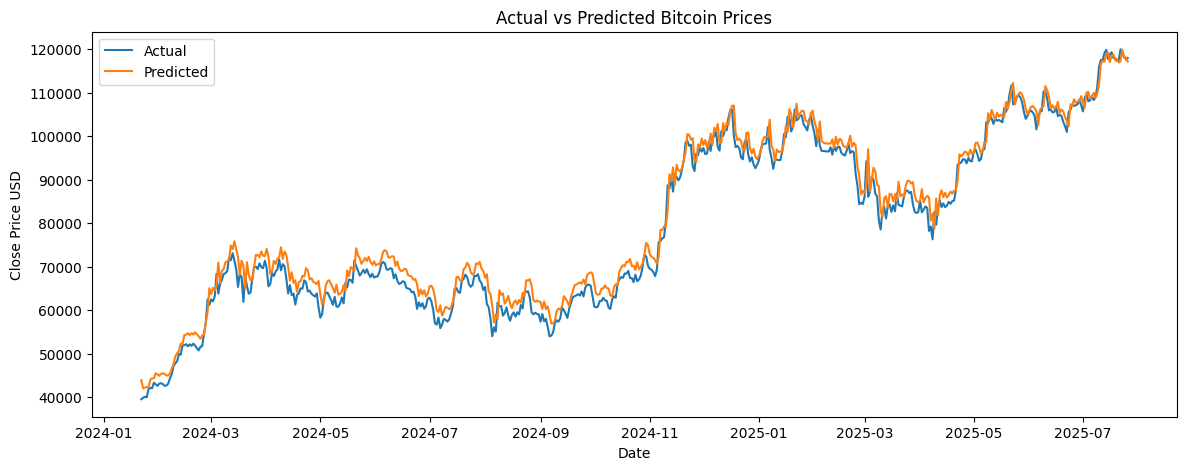

In [ ]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Calculate RMSE, MAE, and R2 score
rmse = np.sqrt(mean_squared_error(valid['Close'], valid['Predictions']))
mae = mean_absolute_error(valid['Close'], valid['Predictions'])
r2 = r2_score(valid['Close'], valid['Predictions'])

print(f"Root Mean Squared Error (RMSE): {rmse}")
print(f"Mean Absolute Error (MAE): {mae}")
print(f"R-squared (R2): {r2}")

# Plotting actual vs predicted values
plt.figure(figsize=(14, 5))
plt.plot(valid['Close'], label='Actual')
plt.plot(valid['Predictions'], label='Predicted')
plt.title('Actual vs Predicted Bitcoin Prices')
plt.xlabel('Date')
plt.ylabel('Close Price USD')
plt.legend()
plt.show()

In [ ]:
import joblib

joblib.dump(model, 'lstm_model.joblib')

joblib.dump(scaler, 'scaler.joblib')

print("Modelo e scaler salvos.")

Modelo e scaler salvos.
